In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
%matplotlib inline
from os.path import join
from matplotlib import pyplot as plt
import pickle
from time import time
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import itertools

In [2]:
PATH_TO_EXPS = 'user_identification_exps\\swt_tuning'

In [14]:
def plot_validation_curves(param_values, grid_cv_results_):
    '''Функция, которая строит валидационные кривые в зависимости от параметра param_values по данным grid_cv_results из
    выхода GridSearchCV'''
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [15]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, test_size=0.3):
    '''Функция, которая проводит кросс-валидацию и тест на отложенной выборке по данным из подаваемых на вход данных
    в формате .pkl'''
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size=test_size, stratify=y)
    
    cv_accuracy = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    estimator.fit(X_train, y_train)
    hold_accuracy = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return cv_accuracy, hold_accuracy

In [4]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [5]:
svm = LinearSVC()

In [6]:
path_to_X_pkl = join(PATH_TO_EXPS, 'X_sparse_10users_s10_w7_t15.pkl')
path_to_y_pkl = join(PATH_TO_EXPS, 'y_10users_s10_w7_t15.pkl')
with open(path_to_X_pkl, 'rb') as X_sparse_pkl:
    X_sparse = pickle.load(X_sparse_pkl)
with open(path_to_y_pkl, 'rb') as y_pkl:
    y = pickle.load(y_pkl)

Найдем лучшее значение С в LinearSVC

In [12]:
%%time
svm_params = {'C': np.logspace(-2, 1, 10), 'max_iter': [2000]}
svm_grid_searcher = GridSearchCV(svm, svm_params, scoring='accuracy', cv=skf, n_jobs=5, return_train_score=True)
svm_grid_searcher.fit(X_sparse, y)

Wall time: 17.8 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=LinearSVC(), n_jobs=5,
             param_grid={'C': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ]),
                         'max_iter': [2000]},
             return_train_score=True, scoring='accuracy')

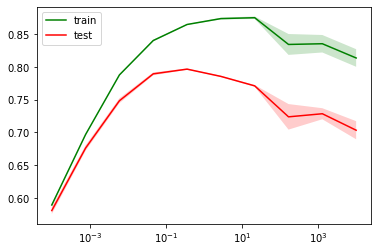

In [11]:
plot_validation_curves(svm_params['C'], svm_grid_searcher.cv_results_)
plt.xscale('log')

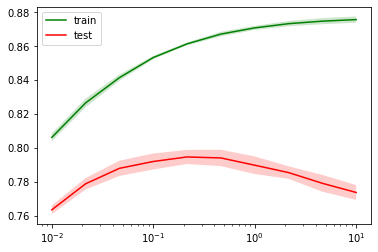

In [13]:
plot_validation_curves(svm_params['C'], svm_grid_searcher.cv_results_)
plt.xscale('log')

In [21]:
print ('Лучший C: {:.3f}'.format(svm_grid_searcher.best_params_['C']))

Лучший C: 0.215


In [16]:
%%time
score_table = []
for window_size, session_length, time_limit in tqdm(list(itertools.product([10, 7, 5], [15, 10, 7, 5], [5, 10, 15, 20, 30]))):
    if window_size <= session_length:
        start_time = time()
        path_to_X_pkl = join(PATH_TO_EXPS, 'X_sparse_10users_s'+str(session_length)+'_w'+str(window_size)+ \
                                     '_t'+str(time_limit)+'.pkl')
        path_to_y_pkl = join(PATH_TO_EXPS, 'y_10users_s'+str(session_length)+'_w'+str(window_size)+ \
                                     '_t'+str(time_limit)+'.pkl')
        accuracy = model_assessment(svm_grid_searcher.best_estimator_, path_to_X_pkl, path_to_y_pkl, skf)
        score_table.append([session_length, window_size, time_limit, 
                           round(accuracy[0], 3), round(accuracy[1], 3), round(time()-start_time, 3)])
score_table = pd.DataFrame(score_table)
score_table.columns = ['session_length', 'window_size', 'time_limit', 'cv_score', 'hold_out_score', 'time']


Wall time: 1min 49s


In [17]:
score_table

,session_length,window_size,time_limit,cv_score,hold_out_score,time
0,15,10,5,0.762,0.779,4.440
1,15,10,10,0.785,0.796,3.640
2,15,10,15,0.788,0.807,2.729
3,15,10,20,0.795,0.818,2.714
4,15,10,30,0.802,0.825,2.683
5,10,10,5,0.715,0.730,1.750
6,10,10,10,0.737,0.742,1.742
7,10,10,15,0.738,0.759,1.692
8,10,10,20,0.740,0.760,1.524
9,10,10,30,0.749,0.759,1.499


In [18]:
score_table.groupby('session_length').mean()[['cv_score', 'hold_out_score']]

,cv_score,hold_out_score
session_length,,
5,0.711400,0.7258
7,0.743300,0.7578
10,0.772133,0.7866
15,0.818000,0.8372


In [19]:
score_table.groupby('window_size').mean()[['cv_score', 'hold_out_score']]

,cv_score,hold_out_score
window_size,,
5,0.78075,0.795100
7,0.77440,0.792467
10,0.76110,0.777500


In [20]:
score_table.groupby('time_limit').mean()[['cv_score', 'hold_out_score']]

,cv_score,hold_out_score
time_limit,,
5,0.756778,0.773000
10,0.773111,0.783778
15,0.776667,0.794333
20,0.780667,0.798444
30,0.784111,0.802000


Видим, что лучшие параметры:  
session_length = 15  
window_size = 5  
time_limit = 30 мин  